In [1]:
pip install denoising_diffusion_pytorch

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 53.1/53.1 kB 4.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 41.6/41.6 kB 3.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.


In [2]:
import torch
import torch.nn.functional as F

from datasets import load_dataset
import torchvision
from denoising_diffusion_pytorch import Unet
from torch.optim import Adam
import tqdm
from torch.cuda.amp import GradScaler
import numpy as np
from matplotlib import pyplot as plt 
import matplotlib.animation as animation
scaler = GradScaler()
device = torch.device("cuda")

In [3]:
def linear_beta_schedule(timesteps):
    beta_start = 0.0001
    beta_end = 0.02
    return torch.linspace(beta_start,beta_end,timesteps)

## Parameters of noise

In [4]:
timesteps = 1000

betas = linear_beta_schedule(timesteps).to(device)
alphas = 1.-betas
alphas_cumprod = torch.cumprod(alphas,axis=0) #累乘 
sqrt_alphas_cumprod = torch.sqrt(alphas_cumprod)
sqrt_one_minus_alphas_cumprod = torch.sqrt(1.-alphas_cumprod)
sqrt_recip_alphas = torch.sqrt(1.0/alphas)

alphas_cumprod_prev = F.pad(alphas_cumprod[:-1],(1,0),value=1.0) # t时刻对应的alpht_{t-1}的累乘
posterior_variance = betas*(1.-alphas_cumprod_prev) / (1-alphas_cumprod) # Xt时刻的分布方差

## Dataset

In [5]:
dataset = load_dataset("fashion_mnist")

Extracting data files:   0%|          | 0/4 [00:00<?, ?it/s]

Generating train split:   0%|          | 0/60000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/10000 [00:00<?, ? examples/s]

Dataset fashion_mnist downloaded and prepared to /root/.cache/huggingface/datasets/fashion_mnist/fashion_mnist/1.0.0/8d6c32399aa01613d96e2cbc9b13638f359ef62bb33612b077b4c247f6ef99c1. Subsequent calls will reuse this data.


  0%|          | 0/2 [00:00<?, ?it/s]

In [6]:
print(dataset)

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 10000
    })
})


In [7]:
dataset = load_dataset("fashion_mnist")
image_size = 28
channels =1
batch_size = 128

from torch.utils.data import DataLoader

transform = torchvision.transforms.Compose([
    torchvision.transforms.RandomHorizontalFlip(),
    torchvision.transforms.ToTensor(),
    torchvision.transforms.Lambda(lambda t:(t*2)-1)
])

def transforms(examples):
    examples["pixel_values"] = [transform(image.convert("L")) for image in examples["image"]]
    del examples["image"]
    return examples

transformed_dataset = dataset.with_transform(transforms).remove_columns("label")
dataloader = DataLoader(transformed_dataset["train"],batch_size=batch_size,shuffle=True,num_workers=2)

  0%|          | 0/2 [00:00<?, ?it/s]

In [8]:
transformed_dataset


DatasetDict({
    train: Dataset({
        features: ['image'],
        num_rows: 60000
    })
    test: Dataset({
        features: ['image'],
        num_rows: 10000
    })
})

## Training stage: using $X_t$ to predict the noise $ Z_t$

In [6]:
def extract(a,t,x_shape):
    bs = x_shape[0]
    out = a.gather(-1,t)
    return out.reshape(bs,*((1,)*(len(x_shape)-1))).to(device)# (bs)->(bs,1,1,1)
    

In [100]:
epochs = 50
model = Unet(dim=18,channels=1,dim_mults=(1,2,4),resnet_block_groups=6).to(device)
optimizer = Adam(model.parameters(), lr = 8e-5, betas = (0.9, 0.99))
lf = lambda x: (1 - x / (epochs - 1)) * (1.0 - 0.01) + 0.01  # linear
lr_scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer, lr_lambda=lf)
model.train()
for epoch in range(epochs):
    total_loss = 0.
    progress_bar = tqdm.tqdm(enumerate(dataloader), total=len(dataloader))
    for step,batch in progress_bar:
        batch = batch["pixel_values"].to(device)
        bs = batch.size()[0]
        t = torch.randint(0,timesteps,(bs,),device=device).long()
        
        # generate noise
        noise = torch.randn_like(batch).to(device)
        
        # Adding Noise_T to X_0
        sqrt_alphas_cumprod_t = extract(sqrt_alphas_cumprod,t,batch.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod,t,batch.shape)
        
        x_t = sqrt_alphas_cumprod_t*batch + sqrt_one_minus_alphas_cumprod_t*noise
        predicted_noise = model(x_t,t)
        
        loss = F.smooth_l1_loss(noise,predicted_noise)
        
        loss_item = loss.data
        total_loss += loss_item
        
        optimizer.zero_grad()
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        
        mem = '%.3gG' % (torch.cuda.memory_reserved() / 1E9 if torch.cuda.is_available() else 0)
        s = ('epoch: %10s' + 'loss: %10.4g' + 'Mem: %10s') % ('%g/%g' % (epoch + 1, epochs), total_loss / (step + 1), mem)
        progress_bar.set_description(s)

epoch:      38/50loss:    0.01985Mem:      1.74G: 100%|██████████| 469/469 [01:08<00:00,  6.85it/s]
epoch:      39/50loss:     0.0195Mem:      1.74G:  79%|███████▉  | 371/469 [00:54<00:14,  6.85it/s]


KeyboardInterrupt: 

## Save model

In [101]:
import os
save = {'state_dict': model.state_dict()}
torch.save(save, os.path.join("/kaggle/working/", 'weights.pth'))

## Sampling

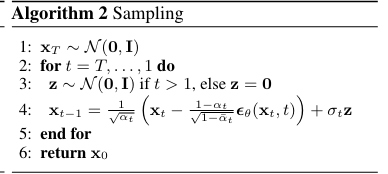

In [8]:
model = Unet(dim=18,channels=1,dim_mults=(1,2,4),resnet_block_groups=6).to(device)
model.load_state_dict(torch.load("/kaggle/input/models/weights.pth")['state_dict'])

<All keys matched successfully>

In [7]:
def reconstruct(input_img,model,reconstruct_steps):
    model.eval()
    imgs = []
    for current_t in tqdm.tqdm(reversed(range(0,reconstruct_steps))):
        bs = input_img.size()[0]
        t = torch.full((bs,),current_t,device=device,dtype=torch.long)

        #calculate the means and std of the distribution of X_{t-1}
        betas_t = extract(betas,t,input_img.shape)
        sqrt_one_minus_alphas_cumprod_t = extract(sqrt_one_minus_alphas_cumprod,t,input_img.shape)
        sqrt_recip_alphas_t = extract(sqrt_recip_alphas,t,input_img.shape)

        # get the prediction noise z_t
        with torch.no_grad():
            z_t = model(input_img,t)
        mean = sqrt_recip_alphas_t*(input_img-betas_t/sqrt_one_minus_alphas_cumprod_t*z_t)

        # 根据均值方差重参数化采样：
        if current_t>0:
            posterior_variance_t = extract(posterior_variance,t,input_img.shape)
            input_img = mean+torch.sqrt(posterior_variance_t)*torch.randn_like(input_img)
        else:
            input_img = mean
        imgs.append(input_img.cpu().numpy())
    return imgs

### Reconstruct an standard normal distribution $X_{t}$ to an image, $X_{0}$

In [9]:
img = torch.randn((16,1,28,28),device=device)  # X_t 随机高斯分布的噪声
imgs = reconstruct(img,model,timesteps)

1000it [00:29, 34.39it/s]


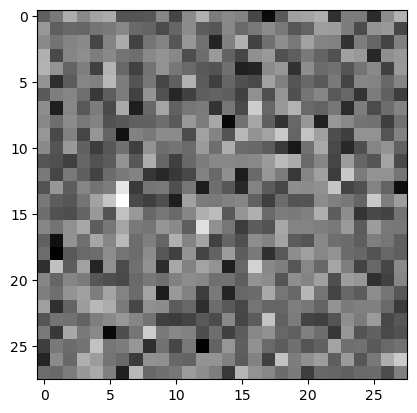

In [15]:
plt.imshow(unnormalize(img[0].cpu().numpy()).reshape(28,28,1),cmap="gray")

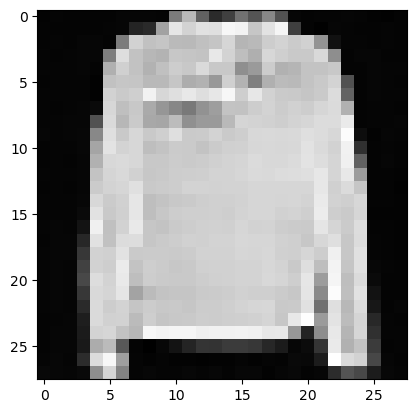

In [13]:
plt.imshow(unnormalize(imgs[-1][1]).reshape(28,28,1),cmap="gray")

In [18]:
def unnormalize(img):
    return (img + 1) * 0.5

## Visualization

### Save as gif

In [68]:
def save_to_gif(imgs,output_path,item_id=0):
    fig = plt.figure()
    ims= []
    for i in tqdm.tqdm(range(timesteps)):   
        if i%10==0:
            im = plt.imshow(unnormalize(imgs[i][item_id]).reshape(image_size,image_size,1),cmap="gray",animated=True)
            ims.append([im])
    for i in range(50):
        im = plt.imshow(unnormalize(imgs[-1][item_id]).reshape(image_size,image_size,1),cmap="gray",animated=True)
        ims.append([im])
    animate = animation.ArtistAnimation(fig,ims,interval=50,blit=True,repeat_delay=1000)
    animate.save(output_path)
    

In [102]:
from matplotlib import pyplot as plt 
import matplotlib.animation as animation

item_id = 4
fig = plt.figure()
ims= []
for i in tqdm.tqdm(range(timesteps)):   
    if i%10==0:
        im = plt.imshow(unnormalize(imgs[i][item_id]).reshape(28,28,1),cmap="gray",animated=True)
        ims.append([im])
for i in range(50):
    im = plt.imshow(unnormalize(imgs[-1][item_id]).reshape(28,28,1),cmap="gray",animated=True)
    ims.append([im])
animate = animation.ArtistAnimation(fig,ims,interval=50,blit=True,repeat_delay=1000)
animate.save("/kaggle/working/diffusion_4.gif")

In [35]:
!cd /kaggle/working

### Claculate the KL-divergence of two distribution.

In [14]:
from scipy.stats import entropy
def cal_kl_divergence_two_tensors(tensor1,tensor2): 
    '''
    tensor1 拟合 tensor2; tensor2 是理想分布
    '''
    bins = np.linspace(-5, 5, 50)
    x_hist, _ = np.histogram(tensor1.cpu().numpy(), bins=bins)
    y_hist, _ = np.histogram(tensor2.cpu().numpy(), bins=bins)
    eps = 1e-9
    x_dist = (x_hist+eps) / np.sum(x_hist)
    y_dist = (y_hist+eps) / np.sum(y_hist)
    kl_divergence = entropy(x_dist, y_dist)
    return kl_divergence

# example:
# tensor_1 = torch.randn((1,28,28)).to(device).view(-1)
# tensor_2 = torch.randn(((1,28,28))).to(device).view(-1)
# print(cal_kl_divergence_two_tensors(tensor_1,tensor_2)) # 0.13
# normal distribution and uniform  distribution would more than 10

### Exp2 Diffuse $X_{0}$ to a standard normal distribution $X_{t}$; and then reconstrut $X_{t}$ to $\hat{X}_{0}$

#### Show the $X_{0}$

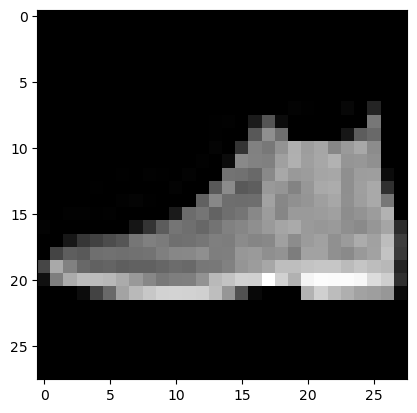

In [22]:
plt.imshow(unnormalize(img_tensor).reshape(28,28,1),cmap="gray")

In [60]:
reconstruct_steps = 1000
img = np.array(dataset["test"]['image'][0].convert("L"))
img_tensor = torchvision.transforms.ToTensor()(img)
img_tensor = img_tensor*2 -1.
img_tensor = img_tensor.unsqueeze(0).to(device)
img_tensor = torch.cat((img_tensor,img_tensor,img_tensor,img_tensor,img_tensor,img_tensor,img_tensor,img_tensor), 0)
noise = torch.randn_like(img_tensor).to(device)
x_t = sqrt_alphas_cumprod[reconstruct_steps-1]*img_tensor + sqrt_one_minus_alphas_cumprod[reconstruct_steps-1]*noise

In [26]:
print("DKL(q(xT |x0) ‖ N (0, I)): ",cal_kl_divergence_two_tensors(img_tensor[0].view(-1),noise[0].view(-1)))

DKL(q(xT |x0) ‖ N (0, I)):  1.8643844673821794


#### Show the $X_{T}$

DKL(q(xT |x0) ‖ N (0, I)):  0.0010155179676979396


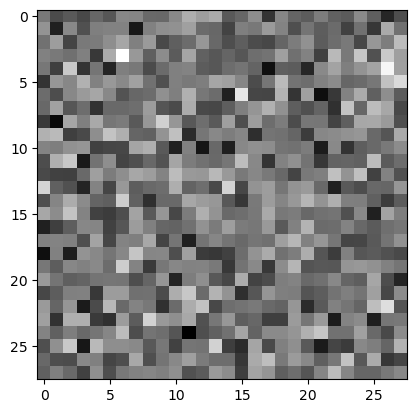

In [61]:
print("DKL(q(xT |x0) ‖ N (0, I)): ",cal_kl_divergence_two_tensors(x_t[0].view(-1),noise[0].view(-1)))
plt.imshow(unnormalize(x_t[0].cpu().numpy()[0]).reshape(28,28,1),cmap="gray")
plt.savefig(f"/kaggle/working/{reconstruct_steps}.png")

In [62]:
# reconstruct
imgs = reconstruct(x_t,model,reconstruct_steps)


1000it [00:25, 39.44it/s]


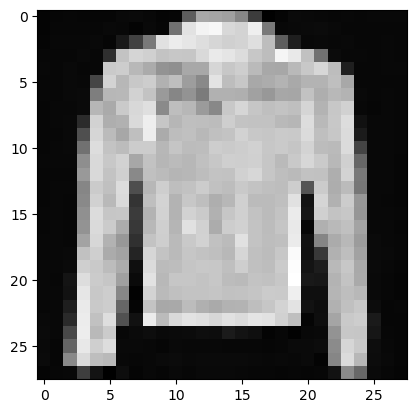

In [66]:
plt.imshow(unnormalize(imgs[-1][1]).reshape(28,28,1),cmap="gray")
plt.savefig(f"/kaggle/working/{reconstruct_steps}_reconstruct.png")

100%|██████████| 1000/1000 [00:00<00:00, 11700.70it/s]


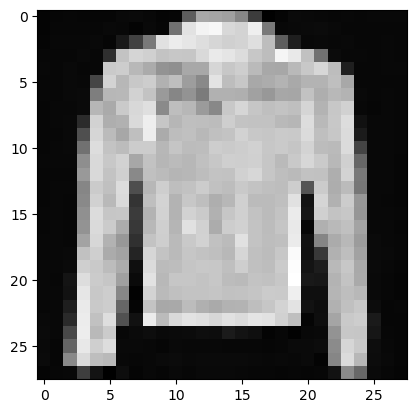

In [69]:
save_to_gif(imgs,"/kaggle/working/exp2.gif",item_id=1)

### Reconstruct from the expoential distribution noise

In [16]:
img = -torch.log(torch.rand((1,1,28,28))) / 0.5
img = img.to(device)
noise =torch.randn_like(img).to(device)
print("DKL(q(xT |x0) ‖ N (0, I)): ",cal_kl_divergence_two_tensors(img[0].view(-1),noise[0].view(-1)))
imgs = reconstruct(img,model,timesteps)

DKL(q(xT |x0) ‖ N (0, I)):  3.769790914105642


1000it [00:27, 35.91it/s]


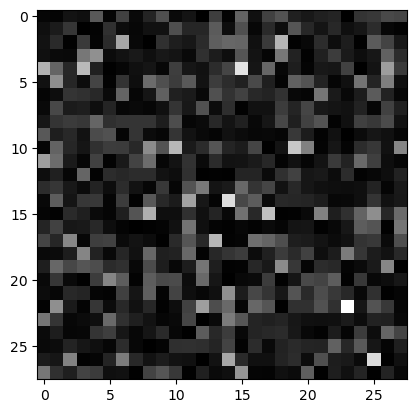

In [19]:
plt.imshow(unnormalize(img[0].cpu().numpy()[0]).reshape(28,28,1),cmap="gray")

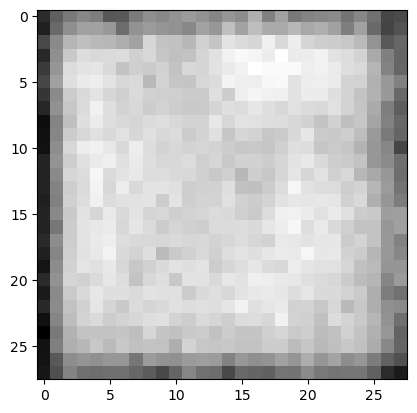

In [23]:
plt.imshow(unnormalize(imgs[-1][0]).reshape(28,28,1),cmap="gray")